In [1]:
seurat = readRDS('initialSeurat.RDS')
hash_data = readRDS('cell hashing/hashed_meta.RDS')
tcr = readRDS('tcr/TCR_df.RDS')
table(hash_data$hash)


 Doublet    HTO10     HTO6     HTO7     HTO8     HTO9 Negative 
    6564     8860     5880     9337     8267     5870     8793 

In [2]:
options(repr.plot.res = 300, repr.plot.width = 4, repr.plot.height = 4)
source("functions.R")

Loading required package: ggplot2

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar

Loading required package: cowplot


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************


Loading required package: Matrix


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [3]:
seurat@meta.data$hash = hash_data[seurat@cell.names, 'hash']
rownames(tcr) = tcr$id
seurat@meta.data$id = paste0(seurat@meta.data$orig, seurat@meta.data$bc)
cols = c('TRB_CDR3', 'TRBV', 'TCR_Recovery', 'TRBJ', 'TRB_nuc', 'TRA_CDR3', 'TRAV', 'TRAJ', 'TRA_nuc', 'TRA.2_CDR3', 'TRAV.2', 'TRAJ.2', 'TRA2_nuc')
seurat@meta.data[,cols] = tcr[seurat@meta.data$id, cols]


HTO10  HTO6  HTO7  HTO8  HTO9 
 4619  3024  2882  2447  2021 

Regressing out: n_genes




Time Elapsed:  35.2317719459534 secs

Scaling data matrix

Warning message:
"Python 'C:\Users\dmorgan\AppData\Local\Continuum\anaconda3\envs\seqwell\python.exe' was requested but 'C:/Users/dmorgan/AppData/Local/r-miniconda/envs/r-reticulate/python.exe' was loaded instead (see reticulate::py_config() for more information)"
Regressing out: n_genes, percent.mito




Time Elapsed:  33.8260300159454 secs

Scaling data matrix



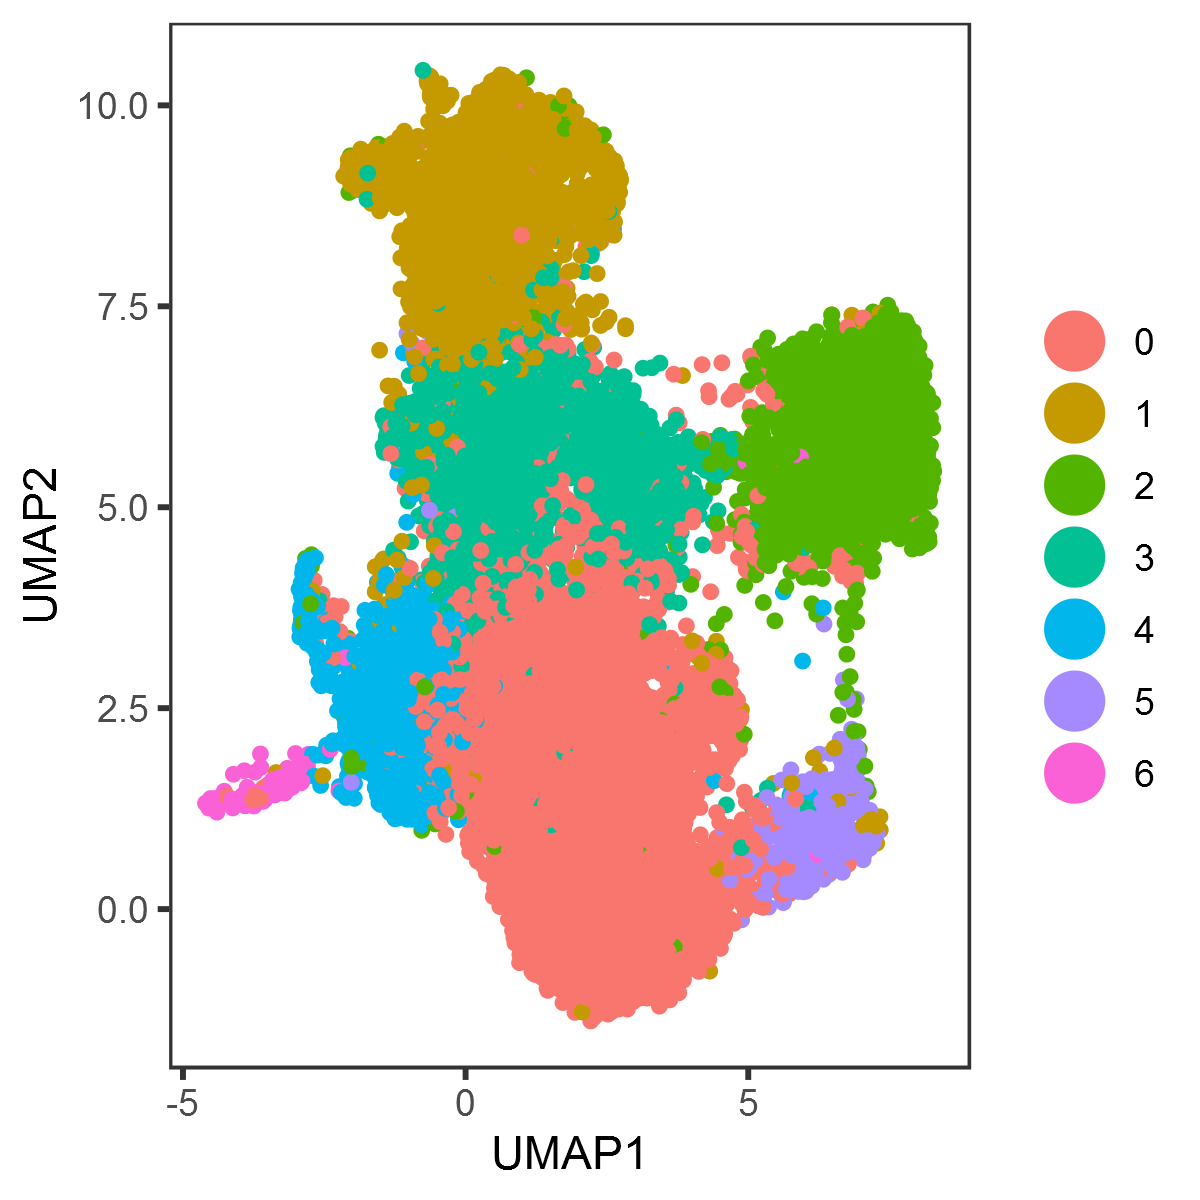

In [4]:
mito.genes = rownames(seurat@data)[grep(x = rownames(seurat@data), pattern = '^mt')]
seurat@meta.data$percent.mito = colSums(seurat@raw.data[mito.genes, seurat@cell.names])/colSums(seurat@raw.data[,seurat@cell.names])
seurat = SubsetData(seurat, seurat@cell.names[seurat@meta.data$n_genes > 500])
seurat = SubsetData(seurat, seurat@cell.names[!seurat@meta.data$hash %in% c('Negative','Doublet')])
seurat = SubsetData(seurat, seurat@cell.names[!is.na(seurat@meta.data$hash)])
seurat = SubsetData(seurat, seurat@cell.names[!seurat@meta.data$orig %in% c('Q1', 'Q2', 'R1', "R2", 'Q3', 'Q4', 'Q5')])
seurat = SubsetData(seurat, seurat@cell.names[seurat@meta.data$percent.mito < .20], subset.raw = TRUE)
table(seurat@meta.data$hash)
seurat = pyProcess(seurat)
seurat = ScaleData(seurat, vars.to.regress = c( 'n_genes', 'percent.mito'), model.use = 'poisson', genes.use = seurat@var.genes)
seurat = RunPCA(seurat, pcs.compute = 100, do.print = FALSE)
seurat = RunUMAP(seurat, dims.use = 1:50)
seurat = FindClusters(seurat, dims.use = 1:20, resolution = .3, print.output = FALSE, force.recalc = TRUE)
DimPlot(seurat, 'umap')

In [5]:
a = FindMarkers(seurat, 6, logfc.threshold = .5)
head(a, 10)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Egfr,0.000000e+00,2.2763165,0.569,0.007,0.000000e+00
Col3a1,0.000000e+00,2.0521414,0.536,0.006,0.000000e+00
Fn1,0.000000e+00,1.5698338,0.287,0.007,0.000000e+00
Lamb1,0.000000e+00,1.5135566,0.316,0.007,0.000000e+00
Fgfr1,0.000000e+00,0.8487105,0.220,0.003,0.000000e+00
1810011O10Rik,0.000000e+00,0.7791422,0.187,0.002,0.000000e+00
Tenm4,0.000000e+00,0.7551917,0.182,0.002,0.000000e+00
Plat,2.410554e-300,0.8322341,0.182,0.002,4.107343e-296
Tenm3,6.493425e-296,0.7887541,0.182,0.002,1.106415e-291


In [6]:
a = FindMarkers(seurat, 4, logfc.threshold = .3)
head(a, 10)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
B2m,2.493354e-104,-0.4131312,0.727,0.968,4.248426e-100
mmu-mir-6236,7.622511e-93,0.4348844,0.999,0.999,1.298800e-88
Cfl1,2.725084e-91,-0.3922236,0.345,0.773,4.643271e-87
Mbnl1,7.860237e-89,-0.3558457,0.376,0.792,1.339306e-84
H2-K1,4.434312e-88,-0.3547321,0.807,0.984,7.555624e-84
Eif3f,8.478015e-86,-0.3690403,0.256,0.648,1.444569e-81
Cd3e,9.034622e-84,-0.3417700,0.245,0.632,1.539409e-79
Pnrc1,2.109622e-83,-0.3013955,0.211,0.583,3.594585e-79
Cd47,7.515078e-82,-0.3453949,0.250,0.626,1.280494e-77


In [7]:
a[a$avg_logFC > 0,][1:10,]

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mmu-mir-6236,7.622511e-93,0.4348844,0.999,0.999,1.298800e-88
Malat1,3.071234e-44,0.3123640,0.890,0.919,5.233075e-40
Cd74,9.904365e-03,0.5066573,0.087,0.117,1.000000e+00
Gm10800,1.105858e-01,0.5997132,0.112,0.106,1.000000e+00
NA,NA,NA,NA,NA,NA
NA.1,NA,NA,NA,NA,NA
NA.2,NA,NA,NA,NA,NA
NA.3,NA,NA,NA,NA,NA
NA.4,NA,NA,NA,NA,NA


In [8]:
seurat = SubsetData(seurat, seurat@cell.names[!seurat@meta.data$res.0.3 %in% c(4,6)], subset.raw = TRUE)
seurat

An object of class seurat in project SeuratProject 
 17039 genes across 13548 samples.

In [9]:
seurat = pyProcess(seurat)
seurat = ScaleData(seurat, vars.to.regress = c( 'n_genes', 'percent.mito'), model.use = 'poisson', genes.use = seurat@var.genes)
seurat = RunPCA(seurat, pcs.compute = 100, do.print = FALSE)
seurat = RunUMAP(seurat, dims.use = 1:50)
seurat = FindClusters(seurat, dims.use = 1:20, resolution = .3, print.output = FALSE, force.recalc = TRUE)

Regressing out: n_genes




Time Elapsed:  36.6858849525452 secs

Scaling data matrix

Regressing out: n_genes, percent.mito




Time Elapsed:  44.7131531238556 secs

Scaling data matrix



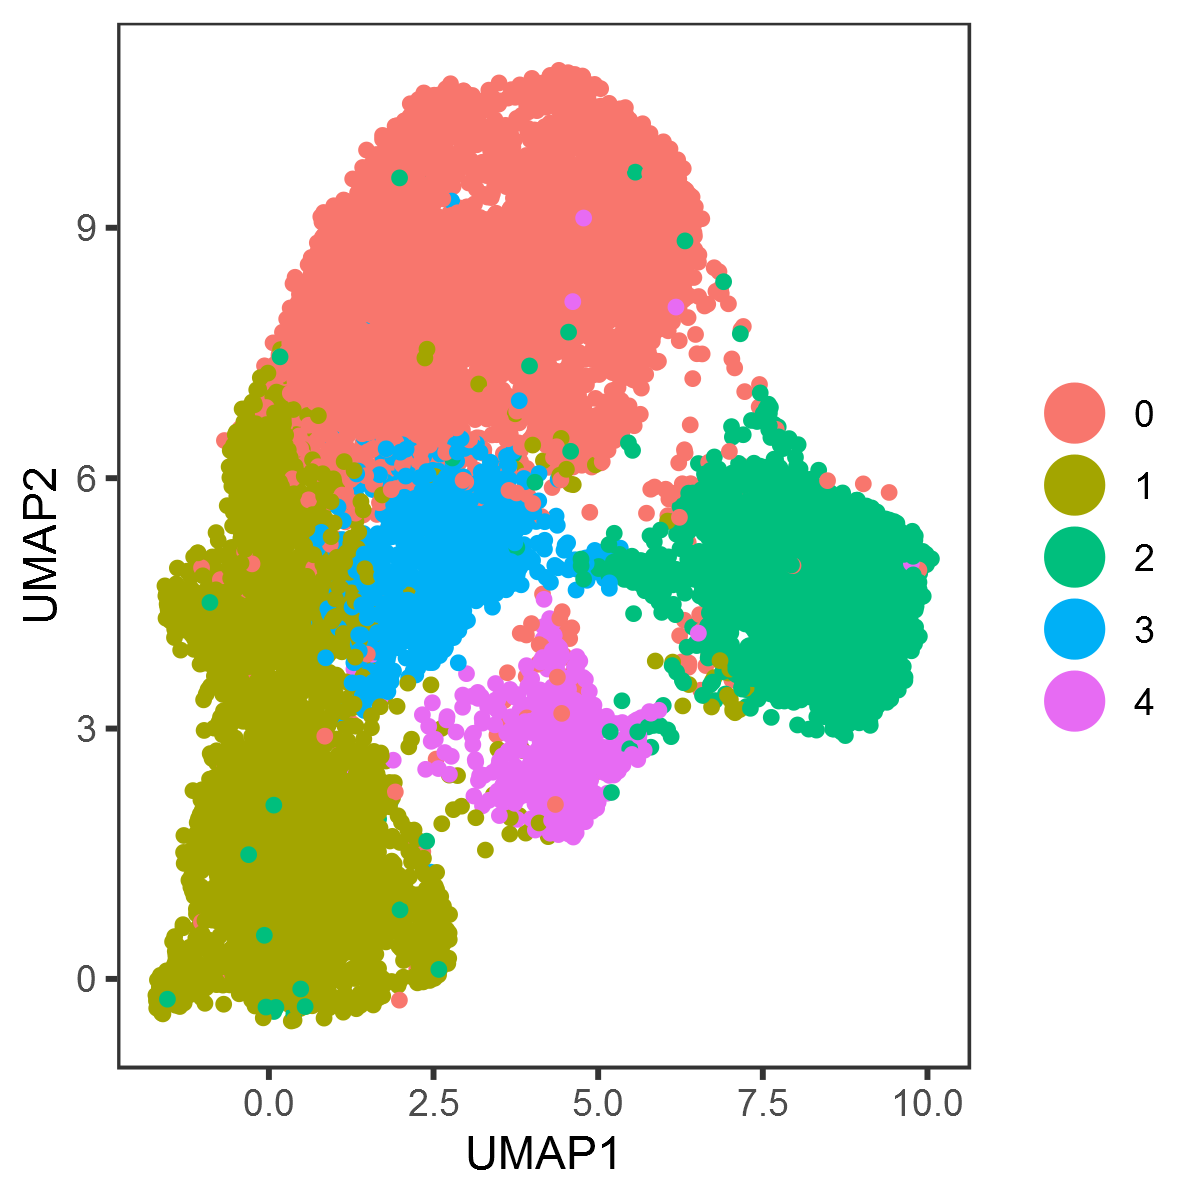

In [10]:
seurat = FindClusters(seurat, dims.use = 1:30, resolution = .2, print.output = FALSE)
DimPlot(seurat, 'umap')

In [11]:
seurat@meta.data$group = 'CAR T'
seurat@meta.data$group[seurat@meta.data$orig %in% c('R7', 'R8', 'Q5', 'Q4')] = 'CAR T-Vax'
seurat@meta.data$group[seurat@meta.data$orig %in% c('R9',' R10')] = 'CAR T-Vax + anti-IFNg'
seurat@meta.data$letter = substring(seurat@meta.data$orig, 1, 1)
seurat@meta.data$time = ifelse(seurat@meta.data$letter == 'Q', 'Day 7', 'Day 14')
seurat@meta.data$time = factor(seurat@meta.data$time, levels =c ('Day 7', 'Day 14'))

table(seurat@meta.data$group)


                CAR T             CAR T-Vax CAR T-Vax + anti-IFNg 
                10722                  1630                  1196 

In [12]:
source('figure_parameters.R')


                CAR T_Day 14             CAR T-Vax_Day 14 
                       10722                         1630 
CAR T-Vax + anti-IFNg_Day 14 
                        1196 

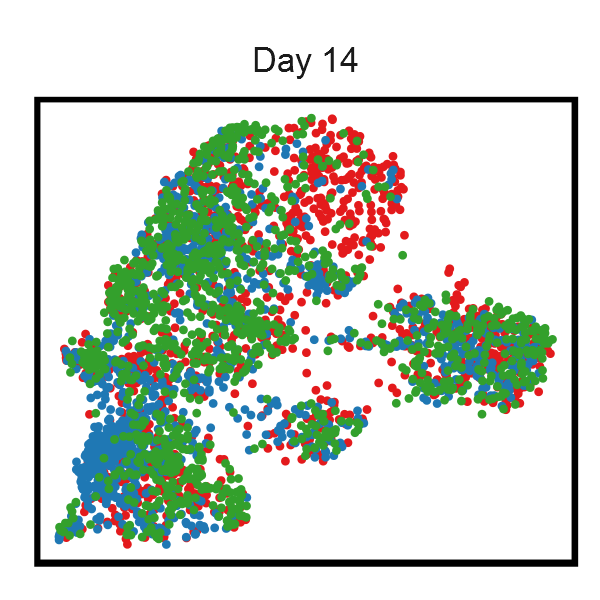

In [13]:
seurat = addUMAP(seurat)
options(repr.plot.width = 5, repr.plot.height = 2.5)


seurat@meta.data$group = factor(seurat@meta.data$group, levels = c('CAR T', 'CAR T-Vax', 'CAR T-Vax + anti-IFNg'))
seurat@meta.data$group_time = paste0(seurat@meta.data$group, '_', seurat@meta.data$time)
seurat@meta.data$group_time = factor(seurat@meta.data$group_time, levels = c('CAR T_Day 14', 'CAR T-Vax_Day 14', 'CAR T-Vax + anti-IFNg_Day 14') )
table(seurat@meta.data$group_time)


condition_palette = brewer.pal(10, 'Paired')[c(6,2,4)]
names(condition_palette) =  names(table(seurat@meta.data$group_time))
set.seed(1)
options(repr.plot.width = 2, repr.plot.height = 2)

ggplot(shuffle(seurat@meta.data) %>% group_by(group_time) %>% sample_n(1196), aes(x = UMAP1, y = UMAP2, color = group_time)) + geom_point(size = .1) + UMAP_theme + scale_color_manual(values = condition_palette) + facet_wrap('time') +
theme(strip.text = element_text(size = 6), strip.background = element_blank())


ggsave('Figures/aifn_condition_umap.pdf', height = 2.2, width = 2, useDingbats = FALSE)

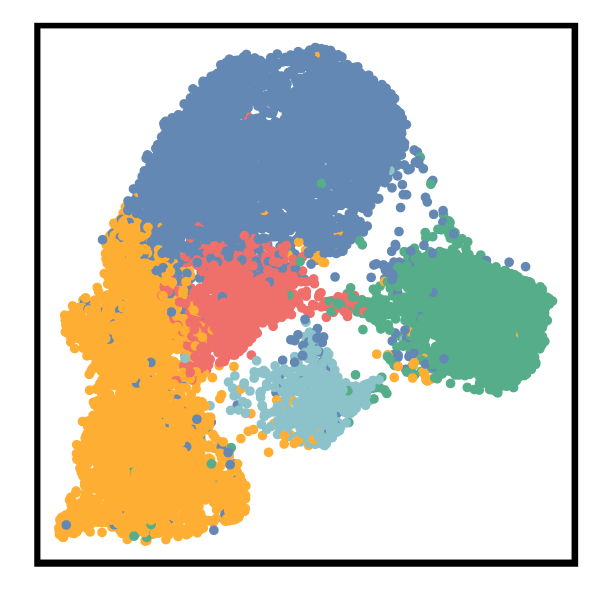

In [14]:
pheno_palette = c('#6388b4', '#ffae34', '#ef6f6a', '#8cc2ca', '#55ad89')#[c(1,2,5,4,3)]
names(pheno_palette) = c('CD4+ Th', 'CD8+ CTL', 'IFN-activated', 'Ki-67+', 'Treg')

seurat@meta.data$pheno = 'CD8+ CTL'
seurat@meta.data$pheno[seurat@meta.data$res.0.2 == 4] = 'Ki-67+'
seurat@meta.data$pheno[seurat@meta.data$res.0.2 == 0] = 'CD4+ Th'
seurat@meta.data$pheno[seurat@meta.data$res.0.2 == 2] = 'Treg'
seurat@meta.data$pheno[seurat@meta.data$res.0.2 == 3] = 'IFN-activated'

seurat@meta.data$pheno = factor(seurat@meta.data$pheno, levels = c('CD4+ Th', 'CD8+ CTL', 'Treg', 'Ki-67+', 'IFN-activated'))

seurat = addUMAP(seurat)
options(repr.plot.width = 2, repr.plot.height = 2)
ggplot(shuffle(seurat@meta.data) , aes(x = UMAP1, y = UMAP2, color =pheno)) + geom_point(size = .2) + UMAP_theme + scale_color_manual(values = pheno_palette)

ggsave('Figures/aifng_pheno_umap.pdf', height = 2, width = 2, useDingbats = FALSE)


                CAR T_Day 14             CAR T-Vax_Day 14 
                       10722                         1630 
CAR T-Vax + anti-IFNg_Day 14 
                        1196 

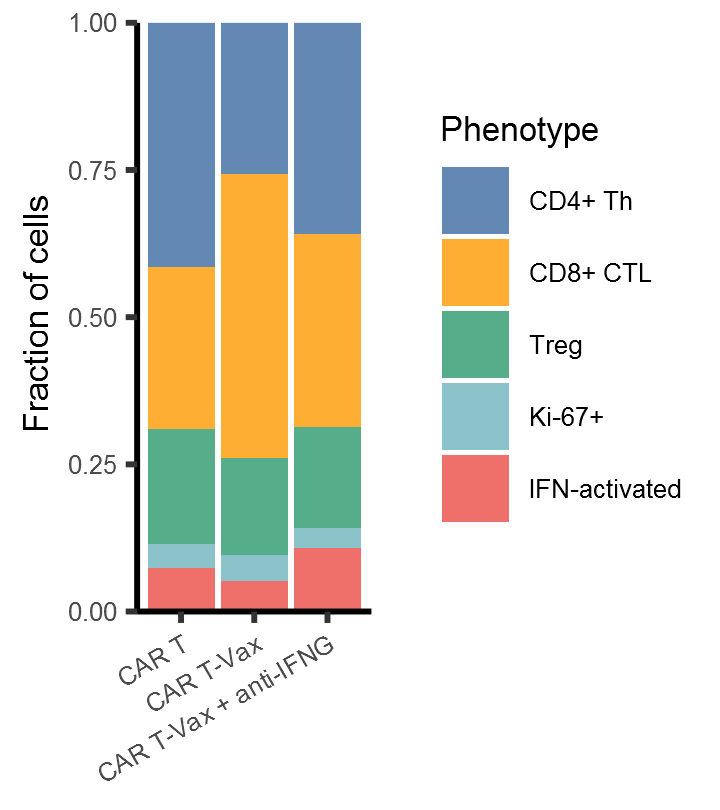

In [15]:

options(repr.plot.width = 2.4, repr.plot.height =2.7 )
table(seurat@meta.data$group_time)
seurat@meta.data$group_time = factor(seurat@meta.data$group_time, levels = c('CAR T_Day 14', 'CAR T-Vax_Day 14', 'CAR T-Vax + anti-IFNg_Day 14'))
ggplot(seurat@meta.data, aes(x = group_time, fill = pheno)) + geom_bar(position = 'fill') + scale_fill_manual(values = pheno_palette) + 
theme_classic() + scale_y_continuous(limits = c(0, 1), expand = expansion(mult = c(0, 0))) + Axis_themes + 
labs(x = c(), y = 'Fraction of cells', fill = 'Phenotype') + theme(axis.text.x = element_text(angle = 30, hjust = 1)) +
scale_x_discrete(labels = c('CAR T', 'CAR T-Vax','CAR T-Vax + anti-IFNG'))
ggsave('Figures/aifn_pheno_condition.pdf', height = 2.7, width = 2.5, useDingbats = FALSE)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Ccl5,2.936539e-63,1.2517123,0.912,0.55,5.003570e-59
Gm26924,2.186561e-56,-0.2771992,1.000,1.00,3.725681e-52
mt-Rnr2,5.390142e-49,0.3041598,1.000,1.00,9.184262e-45
Rpl13a,3.553113e-38,0.4909480,0.986,0.98,6.054149e-34
mt-Rnr1,8.706049e-37,0.3054979,1.000,1.00,1.483424e-32



background     group1     group2 
      4914          7          4 

Warning message:
"Removed 4914 rows containing missing values (geom_text_repel)."
Warning message:
"Removed 4914 rows containing missing values (geom_text_repel)."


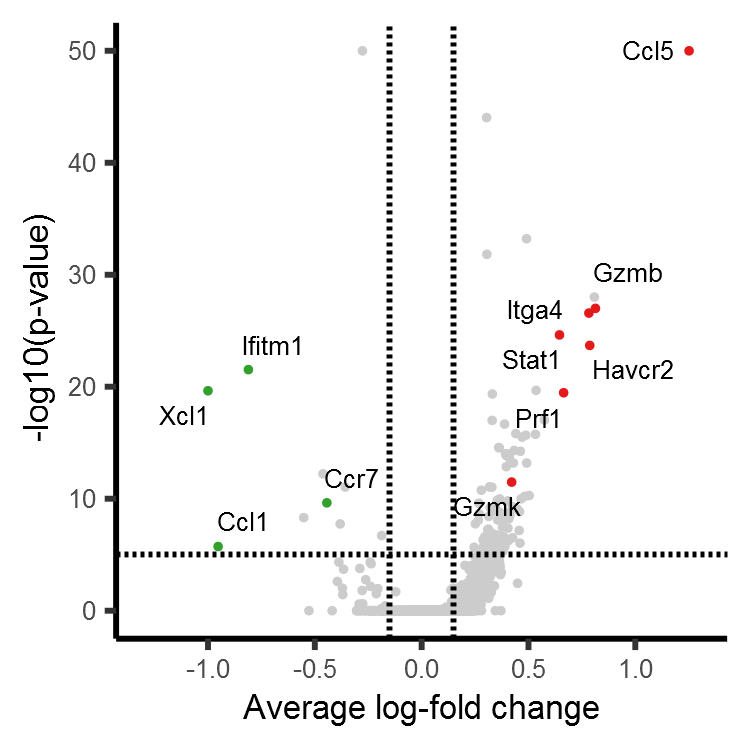

In [16]:
library(ggrepel)
library(stringr)
seurat@meta.data$three = paste(seurat@meta.data$group, seurat@meta.data$pheno, seurat@meta.data$time, sep = '_')
#table(seurat@meta.data$three)
options(repr.plot.width = 2.5, repr.plot.height = 2.5)

seurat = SetAllIdent(seurat, 'three')#
a = FindMarkers(seurat, 'CAR T-Vax_CD8+ CTL_Day 14', 'CAR T-Vax + anti-IFNg_CD8+ CTL_Day 14', logfc.threshold = 0)
head(a, 5)
rownames(a) =str_to_title(rownames(a))
markers.plot = c('Ccl5', 'Gzmb', 'Havcr2', 'Itga4',  'Xcl1', 'Gzmk', 'Ccr7',  'Ccl1', 'Ifitm1', 'Stat1', 'Prf1')
a$format_gene = str_to_title(rownames(a))
a$label = a$format_gene
a$label[!a$format_gene %in% markers.plot] = NA

a$avg_logFC[a$avg_logFC < -1] = -1

a$color = 'background'
a$color[!is.na(a$label)] = 'group1'
a$color[!is.na(a$label) & a$avg_logFC < 0] = 'group2'
a$p_val_plot = a$p_val_adj
a$p_val_plot[a$p_val_adj < 1e-50] = 1e-50

table(a$color)

ggplot(a, aes(x = avg_logFC, y = -log10(p_val_plot), color = color)) + geom_point(size = .2) + theme_classic() + scale_x_continuous(limits = c(-1.3, 1.3)) + Axis_themes + labs(x = 'Average log-fold change', y = '-log10(p-value)') + 
guides(color = FALSE) + geom_text_repel(aes(label = label), size = 2.11667, color = 'black') + scale_color_manual(values = c('grey80', condition_palette[c(1,3)])) + 
geom_hline(yintercept = 5, linetype = 'dashed') + geom_vline(xintercept = .15, linetype = 'dashed') + geom_vline(xintercept = -.15, linetype = 'dashed')




ggsave('Figures/cd8_aifn_vax_volano.pdf', height = 2.5, width = 2.5, useDingbats = FALSE)
write.csv(a, 'vax14-vs_aifn14.csv')

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Gm26924,2.239846e-61,-0.3189639,1.000,1.000,3.816473e-57
Tmsb10,4.564389e-28,0.6992320,0.855,0.636,7.777262e-24
mt-Rnr2,8.528679e-26,0.2569385,1.000,1.000,1.453202e-21
Ptprc,4.903108e-25,0.4586420,0.967,0.910,8.354406e-21
Ms4a4b,4.731543e-24,0.6517366,0.793,0.501,8.062075e-20



background     group1     group2 
      4508          8          2 

Warning message:
"Removed 4508 rows containing missing values (geom_text_repel)."
Warning message:
"Removed 4508 rows containing missing values (geom_text_repel)."


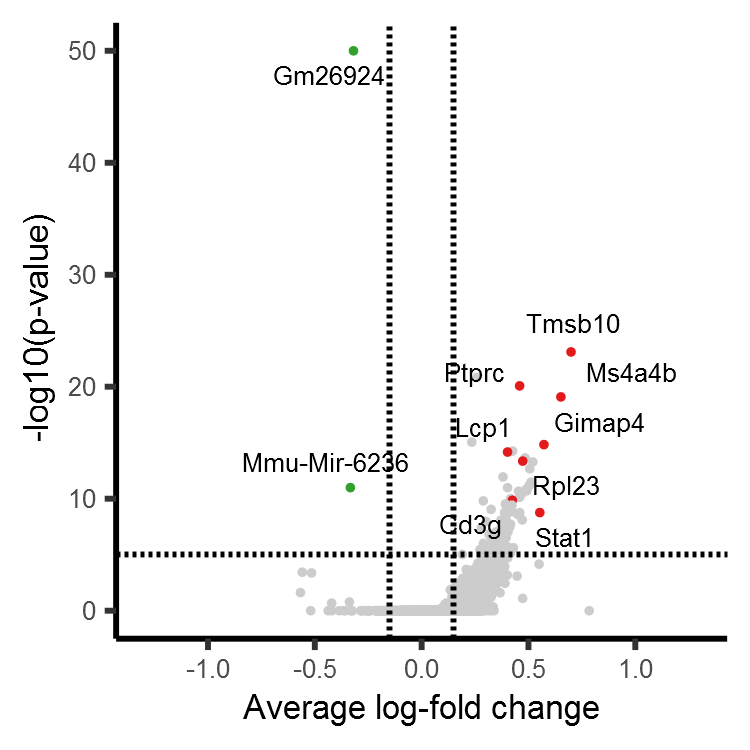

In [17]:
library(ggrepel)
library(stringr)
seurat@meta.data$three = paste(seurat@meta.data$group, seurat@meta.data$pheno, seurat@meta.data$time, sep = '_')
#table(seurat@meta.data$three)
options(repr.plot.width = 2.5, repr.plot.height = 2.5)

seurat = SetAllIdent(seurat, 'three')#
a = FindMarkers(seurat, 'CAR T-Vax_CD4+ Th_Day 14', 'CAR T-Vax + anti-IFNg_CD4+ Th_Day 14', logfc.threshold = 0)
head(a, 5)
rownames(a) =str_to_title(rownames(a))
markers.plot = c('Ptprc', 'Ms4a4b', 'Cd3g', 'Stat1', 'Gimap4', "Lcp1", 'Rpl23', 'Tmsb10', 'Gm26924', 'Mmu-Mir-6236')
a$format_gene = str_to_title(rownames(a))
a$label = a$format_gene
a$label[!a$format_gene %in% markers.plot] = NA

a$avg_logFC[a$avg_logFC < -1] = -1

a$color = 'background'
a$color[!is.na(a$label)] = 'group1'
a$color[!is.na(a$label) & a$avg_logFC < 0] = 'group2'
a$p_val_plot = a$p_val_adj
a$p_val_plot[a$p_val_adj < 1e-50] = 1e-50

table(a$color)

ggplot(a, aes(x = avg_logFC, y = -log10(p_val_plot), color = color)) + geom_point(size = .2) + theme_classic() + scale_x_continuous(limits = c(-1.3, 1.3)) + Axis_themes + labs(x = 'Average log-fold change', y = '-log10(p-value)') + 
guides(color = FALSE) + geom_text_repel(aes(label = label), size = 2.11667, color = 'black') + scale_color_manual(values = c('grey80', condition_palette[c(1,3)])) + 
geom_hline(yintercept = 5, linetype = 'dashed') + geom_vline(xintercept = .15, linetype = 'dashed') + geom_vline(xintercept = -.15, linetype = 'dashed')





ggsave('Figures/cd4_aifn_vax_volano.pdf', height = 2.5, width = 2.5, useDingbats = FALSE)
write.csv(a, 'vax14-vs_aifn14_th.csv')

In [18]:
gzm = rownames(seurat@data)[grep(x = rownames(seurat@data), pattern = "Gzm")]
seurat = AddModuleScore(seurat, genes.list = list(list1 = c(gzm)))


In [19]:
data = read.csv('p15E_tcr.csv', stringsAsFactors = FALSE)
head(data)

bclones = data %>% filter(!is.na(TRB_CDR3)) %>% group_by(TRB_CDR3, tet) %>% summarize(n = n()) %>% mutate(frac = n/sum(n))
bclones = bclones %>% filter(tet == 'Tet+', frac  > .8, n > 1) %>% arrange(desc(n))

aclones = data %>% filter(!is.na(TRA_CDR3)) %>% group_by(TRA_CDR3, tet) %>% summarize(n = n()) %>% mutate(frac = n/sum(n))
aclones = aclones %>% filter(tet == 'Tet+', frac  > .8, n > 1) %>% arrange(desc(n))

,X,nGene,nUMI,orig.ident,orig,bc,n_genes,n_counts,leiden,UMAP1,...,TRBV,TRBJ,TRA_CDR3,TRAV,TRAJ,TRA.2_CDR3,TRAV.2,TRAJ.2,chip,TRB_count
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,B9_1,3582,19089,B9,B9,AAAACGTTCGGT,3581,19088,7,-1.9126217,...,TRBV13-1,TRBJ2-4,NA,NA,NA,NA,NA,NA,B9,2
2,B9_6,2246,7316,B9,B9,AACACACCCTAG,2246,7316,1,-0.9023601,...,TRBV16,TRBJ2-7,NA,NA,NA,NA,NA,NA,B9,19
3,B9_11,5569,32470,B9,B9,AACAGACGAGCG,5568,32469,0,-1.7891079,...,TRBV20,TRBJ2-4,CAVSPPDYSNNRLT,TRAV7-3,TRAJ7,NA,NA,NA,B9,3
4,B9_20,491,1698,B9,B9,AACCGTTCACGC,491,1698,6,2.5570545,...,NA,NA,NA,NA,NA,NA,NA,NA,B9,NA
5,B9_25,369,905,B9,B9,AAGAGGATGTCT,369,905,5,-2.4312119,...,NA,NA,NA,NA,NA,NA,NA,NA,B9,NA
6,B9_31,926,4909,B9,B9,AATAAGCTGCTC,926,4909,0,-1.4568304,...,NA,NA,NA,NA,NA,NA,NA,NA,B9,NA


`summarise()` has grouped output by 'TRB_CDR3'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'TRA_CDR3'. You can override using the `.groups` argument.


In [20]:
library(stringdist)
trb = seurat@meta.data$TRB_CDR3
trb = unique(trb[!is.na(trb)])

dmat = stringdistmatrix(trb, c(bclones$TRB_CDR3, method = 'lv'))
mindist = apply(dmat, 1, min)
names(mindist) = trb
seurat@meta.data$mindistb = mindist[seurat@meta.data$TRB_CDR3]
table(seurat@meta.data$group_time, seurat@meta.data$mindistb)

                              
                                  0    1    2    3    4    5    6    7    8
  CAR T_Day 14                  135  138  624 1166 1169  347   97   28    2
  CAR T-Vax_Day 14                1   13   54  138  363   49   61    1    1
  CAR T-Vax + anti-IFNg_Day 14    3   21   71  179  144   56   15    4    0

In [21]:
tra = seurat@meta.data$TRA_CDR3
tra = unique(tra[!is.na(tra)])

dmat = stringdistmatrix(tra, aclones$TRA_CDR3, method = 'lv')
mindist = apply(dmat, 1, min)
names(mindist) = tra
seurat@meta.data$mindista = mindist[seurat@meta.data$TRA_CDR3]
table(seurat@meta.data$group_time, seurat@meta.data$mindista)

                              
                                 0   1   2   3   4   5   6   7   8   9  10  11
  CAR T_Day 14                  96 188 534 660 558 375 295 221 154  60  46   3
  CAR T-Vax_Day 14               2  15  27  19  31 203  11  10  10   2   1   0
  CAR T-Vax + anti-IFNg_Day 14  19  24  53  76  66  64  47  28  25   2   2   0
                              
                                12  33
  CAR T_Day 14                   1   1
  CAR T-Vax_Day 14               0   0
  CAR T-Vax + anti-IFNg_Day 14   0   0

In [22]:
seurat@meta.data$mindistb[is.na(seurat@meta.data$mindistb)] = 15
seurat@meta.data$mindista[is.na(seurat@meta.data$mindista)] = 15
seurat@meta.data$alpha_motif = NA
seurat@meta.data$alpha_motif[grep(seurat@meta.data$TRA_CDR3, pattern = 'DYSNNRLT')] = 'Yes'
seurat@meta.data$alpha_motif[is.na(seurat@meta.data$alpha_motif)] = 'No'

seurat@meta.data$p15 = as.numeric(seurat@meta.data$mindistb <1 
                                  | seurat@meta.data$mindista <1 | seurat@meta.data$alpha_motif == 'Yes')


seurat@meta.data$p15E = ifelse(seurat@meta.data$p15 == 1, 'p15E-specific', 'Unknown specificity')



Loading required package: magrittr


Attaching package: 'ggpubr'


The following object is masked from 'package:cowplot':

    get_legend


`summarise()` has grouped output by 'group_time'. You can override using the `.groups` argument.


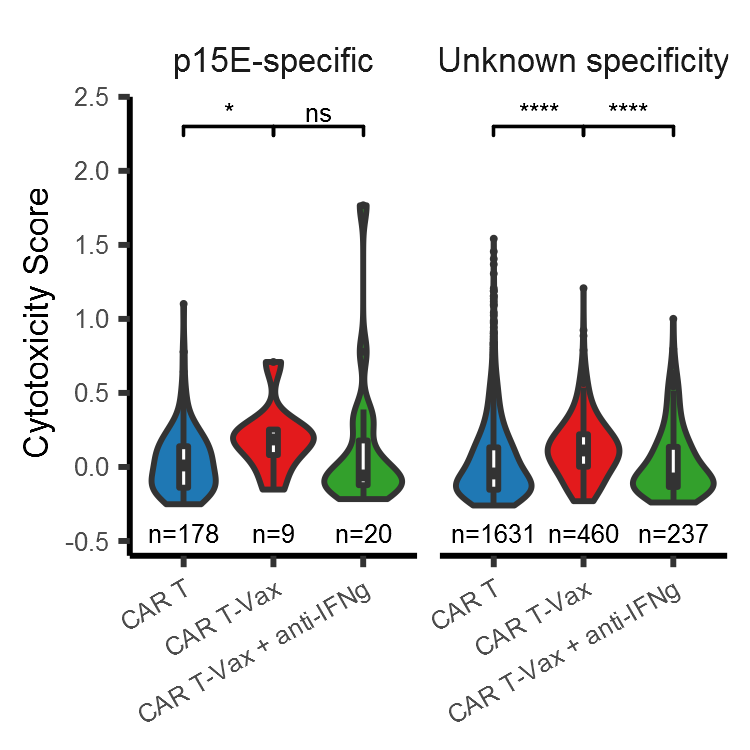

In [23]:
library(ggpubr)
options(repr.plot.res = 300)
count = seurat@meta.data %>% filter(!(is.na(TRB_CDR3) &(is.na(TRA_CDR3))), pheno == 'CD8+ CTL') %>% group_by(group_time,
                                                                                        p15E) %>% summarize(n = n()) %>% mutate(n = paste0('n=', n))
library(RColorBrewer)

condition_palette = brewer.pal(10, 'Paired')[c(6,2,4)][c(2,1,3)]


p=ggplot(seurat@meta.data %>% filter(!(is.na(TRB_CDR3) &(is.na(TRA_CDR3))), pheno == 'CD8+ CTL'), aes(x = group_time, y = Cluster1)) + 
geom_violin(aes(fill = group_time), bw = .1) + geom_boxplot(width = .1, outlier.size = 0) + # geom_jitter(size = .01) + 
geom_text(data =count, aes(x = group_time, label = n), y = -.45, size = 2.1167) + facet_wrap('p15E') +
stat_compare_means(comparisons = list(c(1,2), c(2,3)), label = 'p.signif', label.y = 2.3) + 
 labs(x = c(), y = 'Cytotoxicity Score') + theme_classic() +  Axis_themes + 
scale_x_discrete(labels = c('CAR T', 'CAR T-Vax', 'CAR T-Vax + anti-IFNg'))+
scale_y_continuous(limits = c(-.6, 2.5), expand = c(0,0)) + scale_fill_manual(values = condition_palette) + guides(fill = FALSE) + 
theme(strip.background = element_blank(), axis.text.x = element_text(angle = 30, hjust =1 ))
p$layers[[4]]$aes_params$textsize <- 2.1167
p

ggsave('Figures/p15E_ifng.pdf', height = 3, width = 4, useDingbats = FALSE)